In [6]:
import pandas as pd

photos = pd.read_csv('photos.csv',encoding='latin-1')
depeches = pd.read_csv('depeches.csv')
score_photos = pd.read_csv("scores_freq_photos1.csv")
score_depeches = pd.read_csv("scores_freq_depeches.csv")

/Users/ya/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (10,15,17,23,24,29,30,37) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
import pandas as pd

score_photos = pd.read_csv("scores_freq_photos1.csv")
#score_depeches = pd.read_csv("scores_freq_depeches.csv")
#score_depeches

In [4]:
score_photos.shape

(150536, 3)

In [2]:
pd.set_option("display.max_colwidth",100)
pd.set_option("display.max_columns",500)


In [8]:
photos.dropna(subset=['event'], inplace= True)
depeches.drop_duplicates(subset=['news2','event'], keep='first', inplace=True)
depeches.shape
photos.drop_duplicates(subset='caption', keep='first', inplace=True)
photos.shape
def author_del_photos(text):
    text_s = text
    while(text_s[-7:] != ' / AFP ' and len(text_s) > 1): 
        text_s = text_s[:-1]
    if(len(text_s) <= 1):
        return(text)
    return(text_s[:-7])
photos.caption = photos.caption.apply(author_del_photos)      
depeches.news2 = depeches.news2.apply(lambda x: x.replace('\n', ' '))

In [9]:
liste_ev_unique_depeches, liste_ev_unique_photos = [],[]
for ev in depeches.event:
    for _ev in ev[1:-1].replace("'","").split(', '):
        if _ev not in liste_ev_unique_depeches:
            liste_ev_unique_depeches.append(_ev)
print(len(liste_ev_unique_depeches))
liste_ev_unique_photos = []
for ev in photos.event:

    for _ev in ev[1:-1].replace("'","").split(', '):
        if _ev not in liste_ev_unique_photos:
            liste_ev_unique_photos.append(_ev)
print(len(liste_ev_unique_photos))

13335
16055


In [10]:
# Combien d'evenements sont dans depeches mais pas dans  photos? 
c=0 
for k in liste_ev_unique_depeches:
    if k not in liste_ev_unique_photos:
        c+=1 
print( "Il y a",c," evenements parmi", len(liste_ev_unique_depeches)," evenements dans depeches qui ne sont pas dans photos")

c=0 
for k in liste_ev_unique_photos:
    if k not in liste_ev_unique_depeches:
        c+=1 
print( "Il y a",c," evenements parmi ", len(liste_ev_unique_photos)," dans photos qui ne sont pas dans depeches")
# Combien de depeches ont des evenements dans photos ? 


Il y a 10356  evenements parmi 13335  evenements dans depeches qui ne sont pas dans photos
Il y a 13076  evenements parmi  16055  dans photos qui ne sont pas dans depeches


In [11]:
# Combien de depeches ont au moins un evenement en commun avec une photo  ? 
# Index_inter est l'index des depeches qui ont au moins un evenement en commun avec une photo. 
from tqdm import tqdm_notebook
c= 0 
index_inter = []
for i in tqdm_notebook((depeches.index)):
    L = depeches.event[i][1:-1].replace("'","").split(', ')
    nb = len(L)
    for j in L:
        if j in liste_ev_unique_photos and nb>1:
            c+=1
            index_inter.append(i)
            break
        if j in liste_ev_unique_photos and nb==1:
            c+=1
            index_inter.append(i)
c
     

/Users/ya/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


10137

In [ ]:
index_inter

# Test d'association des depeches avec des photos
>  Pour les 100 premieres depeches.

In [12]:
from tqdm import tqdm_notebook as tq
import ast 
liste_scores1_photos=[]
for string in tq(score_photos.scores):
    liste_scores1_photos.append(ast.literal_eval(string))   

#liste_scores1_depeches=[]
#for string in score_depeches.scores:
#    liste_scores2.append(ast.literal_eval(string))    

/Users/ya/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [13]:
def normaliser_dict(l):
    
    for dico in l:
        m=0
        if len(dico) != 0 :
            m = max(dico.values())
            if m >0 : # Possible que m =0 si description en Francais...
                for k in dico.keys():
                    dico[k] /= m 
                    
normaliser_dict(liste_scores1_photos)


In [14]:
import spacy 
import neuralcoref
#Toute cette cellule est issue de l'autre notebook (création du csv) et permet donc d'avoir toutes les fonctions
#définies dans ce dernier à disposition.


#On importe le fichier contenant les scores de chaque fonction grammaticale
scoring = pd.read_csv('scoring.csv', delimiter = ";")
dict_val = {}

for i in range(48):
    dict_val[scoring['function'][i]] = scoring['score_norm'][i]

#On importe un modèle md pour avoir des mots vectorisés
nlp=spacy.load("en_core_web_md")  
neuralcoref.add_to_pipe(nlp,greedyness=0.5)

/Users/ya/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: spacy.morphology.Morphology size changed, may indicate binary incompatibility. Expected 104 from C header, got 112 from PyObject
  return f(*args, **kwds)
/Users/ya/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: spacy.vocab.Vocab size changed, may indicate binary incompatibility. Expected 96 from C header, got 104 from PyObject
  return f(*args, **kwds)


In [45]:
def dep_ent(ent, doc):
    """ Retourne la fonction grammaticale :  la 'dep', d'une entité. Cette fonction est nécessaire car elle permet d'affecter
    une dep à une entité composée de plusieurs mots ayant chacun une dep de base.
    Traite aussi le cas particulier des mots étant des conj ou des compound : leur vrai dep et celle du mot auxquels
    ils sont associés en tant que conj ou compound."""
    start= ent.start
    end=ent.end
    for k in range(start,end):
        if doc[k].head.text not in ent.text: 
            if doc[k].dep_=='conj':     
                tok=doc[k]            
                while tok.dep_=='conj':
                    tok=tok.head      
                return(tok.dep_)
            
            if doc[k].dep_=='compound':   
                tok=doc[k]            
                while tok.dep_=='compound':
                    tok=tok.head      
                return(tok.dep_)
            return(doc[k].dep_)    
    return doc[start].dep_

## RAJOUT DE FAC
def ent_good_type(ent): #filtre les entités selon leur type 
    return (ent.label_ == "PERSON"or ent.label_ == "NORP" or ent.label_ == "ORG" or ent.label_ == "GPE" or ent.label_ == "EVENT" or ent.label_ == "LOC" or ent.label_ == "FAC")

def sort_ent(doc):
    """Retourne la liste des entités en les filtrant selon leur type et en les triant de manière à avoir au début de
    la liste les entités ayant des coréférences."""
    ent_coref=[ent for ent in doc.ents if ent._.is_coref and ent_good_type(ent)]
    ent_vanilla=[ent for ent in doc.ents if ent_good_type(ent) and not ent._.is_coref]
    return ent_coref + ent_vanilla

def scores_doc(doc):
    """Retourne le score de chaque entité pour la méthode sans neuralcoref."""
    res={}
    for ent in doc.ents:
        if ent.text not in res.keys():
            res[ent.text]=dict_val[dep_ent(ent,doc)]
        else:
            res[ent.text]+=dict_val[dep_ent(ent,doc)]
    return res

def scores_doc_coref1(doc):
    """Retourne le score de chaque entité pour la méthode de base opérée sur le document resolved.
    Le document resolved est le document de base dans lequel toutes les références à un groupe de mot sont remplacées
    par celui-ci.
    Par exemple : My dad is home. He watches TV devient My dad is home. My dad watches TV.
    En raisonnant avec le nlp sur le document resolved, le nlp va détecter beaucoup plus de fois la même entité.
    Le principal inconvénient est que toutes les références sont remplacées, y compris celles qui ne sont pas associées 
    à des entités mais plutôt à des très longs bouts de phrase qui sont repris par un pronom comme "it"  """
    
    doc=nlp(doc._.coref_resolved)
    res={}
    for ent in doc.ents:
        if ent_good_type(ent):
            if ent.text not in res.keys():
                res[ent.text]=dict_val[dep_ent(ent,doc)]
            else:
                res[ent.text]+=dict_val[dep_ent(ent,doc)]
    #normaliser_dict
    m=0
    if len(res) != 0 :
        m = max(res.values())
    if m >0 : # Possible que m =0 si description en Francais...
        for k in res.keys():
            res[k] /= m 

    return res

def is_in_cluster(ent,cluster):  #détermine si une entité est dans une des mentions d'un cluster
    for span in cluster.mentions:
        if ent.text in span.text:
            return True
    return False



def freq_dict(L):
    n = len(L)
    L_unique = list(set(L))
    d = {}
    for a in L_unique:
        for b in L:
            if a == b:
                if a in d.keys():
                    d[a] += 1/n
                else:
                    d[a] = 1/n
    return(d)

In [16]:

def score_sim1(doc,score_doc,k):
    """Prend en paramètre un doc, le fichier de scores associés à ce doc et un entier k correspondant à l'indice de la 
    description avec laquelle on veut comparer le doc. Retourne le score de similarité entre le doc et la description.
    Ici on calcule le score avec la méthode neuralcoref1 : on utilise liste_scores1."""
    res=0
    score_image=liste_scores1_photos[k]
    for i in score_doc.keys():
        if i in score_image.keys():
            res += (score_doc[i]+score_image[i])/2 #- abs(freq_doc[i]-freq_image[i])/2
    return res

def score_sim11(doc,score_doc,k):
    """Prend en paramètre un doc, le fichier de scores associés à ce doc et un entier k correspondant à l'indice de la 
    description avec laquelle on veut comparer le doc. Retourne le score de similarité entre le doc et la description.
    Ici on calcule le score avec la méthode neuralcoref1 : on utilise liste_scores1.
    Rajout d'une pénalité par entité différentes 
    """
    res=0
    score_image=liste_scores1_photos[k]
    for i in score_doc.keys():
        if i in score_image.keys():
            res += (score_doc[i]+score_image[i])/2 #- abs(freq_doc[i]-freq_image[i])/2
    score_image_tri = tri_dict(score_image)
    c = 0 
    for i in score_image_tri.keys():
        c+=1
        if i not in score_doc.keys():
            
            res -= 1/(c+1)**2
        
    return res


def related_descr(doc):
    """Retourne la liste des indices correspondant aux descriptions ayant au moins 1 entité en commun avec le doc.
    Permet d'effectuer moins de comparaison dans la fonction best_image."""
    index_list=[]
    for k in range(len(liste_scores1_photos)):
        for ent in doc.ents:
            if ent.text in liste_scores1_photos[k].keys():
                index_list.append(k)
                break
    return index_list

def best_image1(doc):
    """Retourne l'indice de l'image dont la description correspond le plus au doc passé en paramètre.
    La correspondance (matching) se fait avec score_sim1."""
    best_score=0
    best_descr=0
    score_doc=scores_doc_coref1(doc)
    for k in range(len(liste_scores1_photos):
        if score_sim1(doc,score_doc,k) > best_score:
            best_score=score_sim1(doc,score_doc,k)
            best_descr=k
    return best_descr



def best_image11(doc):
    """Retourne l'indice de l'image dont la description correspond le plus au doc passé en paramètre.
    La correspondance (matching) se fait avec score_sim1."""
    best_score=0
    best_descr=0
    score_doc=scores_doc_coref1(doc)
    for k in range(len(liste_scores1_photos):
        if score_sim11(doc,score_doc,k) > best_score:
            best_score=score_sim11(doc,score_doc,k)
            best_descr=k
    return best_descr


In [129]:
photos['index'] = range(photos.shape[0])
photos.set_index('index',inplace=True)

In [18]:
def tri_dict(d): 
    """Tri décroissant """

    d_sort = {}
    for k,v in sorted(d.items(), key =lambda x :x[1], reverse= True):
        d_sort[k]=v
    return d_sort
    
best_image11(nlp(depeches.news2[4]))

11100

In [19]:
%%time
def event_commun(k): 
    L = []
    event = depeches.event[k][1:-1].split((','))
    for c in event: 
        for i in range(photos.shape[0]):
            if c in (photos.event[i][1:-1].split(',')):
                L.append(i)
    return L
            


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


In [121]:
def best_images(k, malus):
    """ Retourne les  meilleures ( best score) photos de la k eme dépèche"""
    doc = nlp(depeches.news2[k])
    L_score =[]
    score_doc=scores_doc_coref1(doc)
    if malus : 
        for j in range(len(liste_scores1_photos)):
            L_score.append( (score_sim11(doc,score_doc,j),j)) 
    else : 
         for j in range(len(liste_scores1_photos)):
            L_score.append( (score_sim1(doc,score_doc,j),j)) 
    L_score.sort(reverse=True)
    
    return L_score


### Comment tester : 
> Chaque point un nouveau compteur
*  Compter un si la meilleure photo a des evenements en commun avec la depeche
*  Compter un si une des 10 meilleures photos a des evenements en commun avec la depèche 
*  De meme avec 5. 
*  Faire le graphe la position de la premiere photo ayant un evenement en commun 


# Afficher la distibution 

Avec malus

In [46]:
%%time
import matplotlib.pyplot as plt
#P = []
#c1 = 0 
#c2 = 0 
#c3 = 0
for k in tqdm_notebook(index_inter[94:300]):
    liste_event_commun = event_commun(k)
    L = best_images(k,True)
   
    if  L != [] :
        if L[0][1] in liste_event_commun:
                c1+=1
        position = -20
        j=0
        while position == -20 and j<len(L):

            if L[j][1] in liste_event_commun:
                position = j + 1
                score_com = L[j][0]

            j+=1
        if position<=5 and position != -20: 
            c2+=1
        if position<=10 and position != -20:
            c3+=1
        P.append(position)

        
    
    
    


/Users/ya/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



CPU times: user 1h 22min 20s, sys: 30 s, total: 1h 22min 50s
Wall time: 6h 32min 30s


19973

(array([95., 31., 13., 18., 12.,  9.,  6.,  5.,  3.,  5.,  3.,  7.,  3.,
         3.,  5.,  3.,  4.,  3.,  1.,  0.,  2.,  1.,  3.,  2.,  1.,  0.]),
 array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120., 140., 160., 180.,
        200., 220., 240., 260., 280., 300., 320., 340., 360., 380., 400.,
        420., 440., 460., 480., 500.]),
 <a list of 26 Patch objects>)

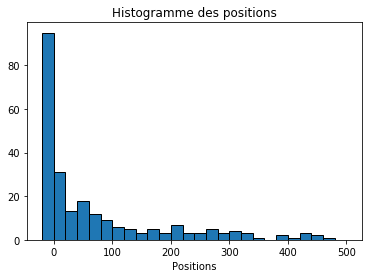

In [47]:
plt.xlabel('Positions')
plt.title('Histogramme des positions')
plt.hist(P, range=(-20,500), bins= 26, edgecolor = 'black' )


In [50]:
%%time
import matplotlib.pyplot as plt
#P_sansmalus = []
#c1 = 0 
#c2 = 0 
#c3 = 0
for k in tqdm_notebook(index_inter[156:300]):
    liste_event_commun = event_commun(k)
    L = best_images(k,False)
   
    if  L != [] :
        if L[0][1] in liste_event_commun:
                c1+=1
        position = -20
        j=0
        while position == -20 and j<len(L):

            if L[j][1] in liste_event_commun:
                position = j + 1
                score_com = L[j][0]

            j+=1
        if position<=5 and position != -20: 
            c2+=1
        if position<=10 and position != -20:
            c3+=1
        P_sansmalus.append(position)

        
    
    
    

/Users/ya/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



CPU times: user 48min 50s, sys: 31.2 s, total: 49min 21s
Wall time: 1h 6min 27s


(array([95., 25., 15.,  6.,  7.,  2.,  6.,  2.,  2.,  6.,  3.,  3.,  4.,
         4.,  2.,  5.,  4.,  2.,  4.,  4.,  2.,  1.,  2.,  2.,  1.,  0.]),
 array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120., 140., 160., 180.,
        200., 220., 240., 260., 280., 300., 320., 340., 360., 380., 400.,
        420., 440., 460., 480., 500.]),
 <a list of 26 Patch objects>)

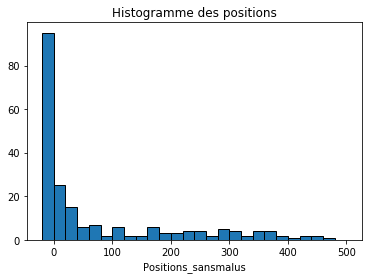

In [52]:
plt.xlabel('Positions_sansmalus')
plt.title('Histogramme des positions')
plt.hist(P_sansmalus, range=(-20,500), bins= 26, edgecolor = 'black' )


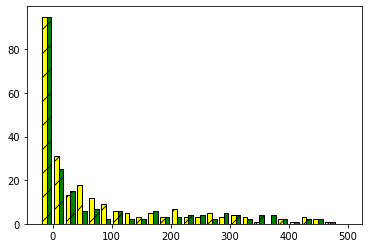

In [119]:
%matplotlib inline
plt.hist([P, P_sansmalus], bins =26,range= (-20,500), color = ['yellow', 'green'], edgecolor = 'black', hatch = '/', label = ['avec malus', 'sans malus'], histtype = 'bar')
plt.show()
# bar est le defaut

In [58]:
d = 0 
v= 0 
for k in P: 
    if 0<=k<=100:
        d+=1
for k in P_sansmalus:
    if 0<=k<=100:
        v+=1
print('le nombre de dépeches dans le top 100 sans malus est de' ,v , '\nle nombre de dépeches dans le top 100 avec malus est de' ,d)
        


le nombre de dépeches dans le top 100 sans malus est de 55 
le nombre de dépeches dans le top 100 avec malus est de 83


In [59]:
d = 0 
v= 0 
for k in P: 
    if 0<=k<=10:
        d+=1
for k in P_sansmalus:
    if 0<=k<=10:
        v+=1

print('le nombre de dépeches dans le top 10 sans malus est de' ,v , '\nle nombre de dépeches dans le top 10 avec malus est de' ,d)
        

le nombre de dépeches dans le top 10 sans malus est de 15 
le nombre de dépeches dans le top 10 avec malus est de 20


In [35]:
%%time
import matplotlib.pyplot as plt

for k in tqdm_notebook(index_inter[95+22:150]):
    liste_event_commun = event_commun(k)
    L = best_images(k,True)
   
    if  L != [] :
        if L[0][1] in liste_event_commun:
                c1+=1
        position = -1000
        j=0
        while position == -1000 and j<len(L):

            if L[j][1] in liste_event_commun:
                position = j + 1
                score_com = L[j][0]

            j+=1
        if position<=5 and position != -1000: 
            c2+=1
        if position<=10 and position != -1000:
            c3+=1
        P.append(position)

        

/Users/ya/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until



CPU times: user 11min 4s, sys: 10.5 s, total: 11min 14s
Wall time: 11min 50s


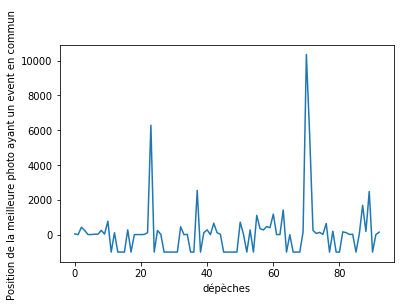

In [29]:
plt.xlabel("dépèches")  
plt.ylabel("Position de la meilleure photo ayant un event en commun ")
plt.plot(range(len(P)),P)  
plt.show()
    

In [30]:
print("Nombre perfect match" , c1, "\n <=5", c2 , " \n <=10", c3 , " sur 150 photos" )

Nombre perfect match 3 
 <=5 8  
 <=10 13  sur 150 photos


## Test article 

In [155]:
df = pd.read_csv('scraping_by_keyword.csv')
df = df.dropna(subset= ['Article'])
df.Article = df.Article.apply(lambda x: x.replace("\n"," "))

In [157]:
df.shape

(5, 3)

In [75]:
%%time
v =nlp(df.Article[0])

CPU times: user 3.18 s, sys: 297 ms, total: 3.47 s
Wall time: 2.52 s


In [74]:
a = scores_doc_coref1(nlp(df.Article[0]))

In [109]:
%%time 
def article_best_images(article, malus):
    """ Retourne les  meilleures ( best score) photos de la k eme dépèche"""
    doc = nlp(article)
    #doc = nlp(depeches.news2[10])
    L_score =[]
    score_doc=scores_doc_coref1(doc)
    #rel = related_descr(doc)
    if malus : 
        for j in range(len(liste_scores1_photos)):
            L_score.append( (score_sim11(doc,score_doc,j),j)) 
    else : 
         for j in range(len(liste_scores1_photos)):
            L_score.append( (score_sim1(doc,score_doc,j),j)) 
    L_score.sort(reverse=True)
    
    return L_score



CPU times: user 8.79 s, sys: 626 ms, total: 9.41 s
Wall time: 7.47 s


In [158]:
# df base de 5 articles sur la korea 
result_malus =article_best_images(df.Article[0], True)
result = article_best_images(df.Article[0], False)


46798

In [161]:
df.Article[0]

"Early this week, a news site in Seoul reported that North Korean leader Kim Jong-un had undergone heart surgery. CNN and Reuters picked up the story, sending speculation rampant. As the coronavirus has quickly reclaimed our total attention, the world is left wondering two things: what’s the actual state of Kim’s health, and how much does it really matter?  Why It Matters:  Let’s start with the fact that there is no way to know what the real situation is with Kim’s health. South Korea has been downplaying the reports for the last few days, saying it has detected “no unusual developments” in the country; but Pyongyang, which is quick to issue denials of news stories it takes even the slightest issue with, has been noticeably silent.  In a pre-Covid-19 world, Kim Jong-un was a comparatively significant world leader on stage, in the sense that he controlled a rogue nuclear power. Well, almost rogue—while North Korea likes to present itself as a self-sufficient power in its own right that 

In [159]:
from IPython.display import Image
from IPython.core.display import HTML 
L = [ photos.url_extracted[k[1]] for k in result[:10] ] 
for i in L :
    display(Image(url= i))
    

In [160]:
from IPython.display import Image
from IPython.core.display import HTML 
L = [ photos.url_extracted[k[1]] for k in result_malus[:10] ] 
for i in L :
    display(Image(url= i))
    

In [173]:
def display_phto(k,nb_photo):
    result_malus =article_best_images(df.Article[k], True)
    result_sansmalus =article_best_images(df.Article[k], False)
    print(df.Article[k])
    L_malus = [ photos.url_extracted[k[1]] for k in result_malus[:nb_photo] ] 
    L_sansmalus= [ photos.url_extracted[k[1]] for k in result_sansmalus[:nb_photo] ] 
    print('Sans malus')
    for i in L_sansmalus :
        display(Image(url= i))
    
    print('malus')
    for i in L_malus  :
        display(Image(url=i))
        
    

In [174]:
display_phto(4,6)

Get all the latest news on coronavirus and more delivered daily to your inbox. Sign up here.  The signature train belonging to North Korean leader Kim Jong Un has been spotted on satellite images parked at a station on the nation's eastern coast since last week, according to a U.S. monitor, as questions swirl over the dictator's health.  Since Kim missed an April 15 commemoration of the 108th birthday of his grandfather, North Korea founder Kim Il Sung, unverified reports have emerged about his health.  On Sunday, a key aide to the president of South Korea insisted Kim, who is believed to be 36, was "alive and well."  "Our government position is firm," Chung-in Moon, foreign policy adviser to South Korean President Moon Jae-in, told Fox News. "Kim Jong Un is alive and well. He has been staying in the Wonsan area since April 13. No suspicious movements have so far been detected."  THE MYSTERY SURROUNDING KIM JONG UN: WHAT'S GOING ON WITH THE NORTH KOREAN DICTATOR'S HEALTH?  Satellite ph

malus


In [192]:
article_time= 'Jerusalem (CNN) The mourners gathered by the hundreds, packed tightly on to the evening streets of Bnei Brak. There was no social distancing -- no two meters between them -- as they made their way down the roads of this ultra-Orthodox town near Tel Aviv for the Saturday night funeral of Rabbi Tzvi Shenkar.\n\nDespite a police presence, the crowd mingled freely, apparently unconcerned about the government restrictions on large gatherings, or the reason behind them.\n\nAs Israel has battled the spread of coronavirus , the government has imposed increasingly tighter restrictions on the public in an attempt to slow the rate of infection. As of Tuesday morning, Israel had 4,831 confirmed cases of coronavirus and 17 deaths as a result of the disease.\n\nThough police say the majority of the public has heeded the instructions, the seriousness of the situation seems yet to have fully penetrated the ultra-Orthodox community.\n\nMore than a week earlier, an ultra-Orthodox wedding in Bet Shemesh near Jerusalem drew a crowd of 150, police said, in violation of government restrictions which limited weddings to ten people. One of those in attendance was supposed to be in quarantine, police said. He was one of three people arrested for endangering public health.\n\n"With the ultra-religious communities, we are definitely emphasizing police units being inside and dispersing people," said police spokesman Micky Rosenfeld. "We\'re seeing gatherings of more than ten people which is against the law," Rosenfeld said, emphasizing instances of religious schools that have remained open, despite orders to close.\n\nIn the ongoing fight against coronavirus, the ultra-Orthodox communities have become the front line. Police officers and SWAT teams have gone into these neighborhoods, warning people of the new restrictions on public gathering and issuing tickets to those who ignore the rules. But too often, the Haredim view civil laws and restrictions as an intrusion into their conservative, strictly religious, lifestyle.\n\nIn Mea Shearim, video from Israel police showed officers showered with cries of "Nazis" and "murderers" as they made their way down the labyrinthine alleys of the insular Jerusalem neighborhood. A medical team from Magen David Adom (MDA), Israel\'s emergency response service, was pelted with rocks in the same neighborhood while trying to carry out a coronavirus test, a spokesman from MDA said.\n\nIsraeli security forces arrest an ultra-Orthodox Jewish man as they close a synagogue in Jerusalem on Monday.\n\nInfection rates in ultra-Orthodox communities are markedly higher than the rest of the country. The ultra-Orthodox communities in Bnei Brak, Mea Shearim, and Kiryat Yearim, which lies between Jerusalem and Tel Aviv, have among the highest infection rates in Israel, Rosenfeld said. A spokesman for the mayor of Bnei Brak said health officials had confirmed the town had the single highest infection rate in the entire country.\n\nIsrael\'s ultra-Orthodox, also known as the Haredim, make up just 14% of the country\'s total population but comprises a disproportionately large number of coronavirus patients. At Tel Hashomer hospital outside Tel Aviv, 60% of the coronavirus patients are ultra-Orthodox, spokesman Steve Walz tells CNN\n\nHaredi communities routinely shun modern technology like internet and smart phones. Despite a gradual modernization movement, the community still relies on posters and signs plastered on street corners to spread important messages and news. On one corner in Mea Shearim, a sign implores the community to heed the government\'s instructions, saying, "Danger! Responsibility Demands," and explains who need to enter self-quarantine. But the sign was ripped apart, with the middle section torn out.\n\nA number of signs nearby shared a very different message about a "Terrible Discovery" that the "Corona Epidemic = A Lack of Modesty." The poster implored women and girls to dress modestly and adhere to religion according to the demands of Jewish law.\n\nA poster with instructions on how to properly sneeze in Jerusalem on Sunday.\n\nDespite outward appearances, the ultra-Orthodox community is not homogenous. Instead it is divided into many different factions and groups, each with its own rabbis and leaders. A directive from one rabbi may not hold sway over the followers of a different rabbi. Some of the groups are defiantly opposed to the existence of the state of Israel, believing it makes less likely the arrival of the Messiah. One of the most radical is known as the Jerusalem faction, which regularly organizes protests against the Israeli government. Police say it was this group that held the funeral in Bnei Brak over the weekend.\n\nEven so, some leading ultra-Orthodox rabbis have begun to instruct their followers to obey government restrictions. Rabbi Chaim Kanievsky, one of the most prominent Haredi religious leaders, warned on religious media outlets that anyone who doesn\'t obey the instructions of the Ministry of Health should be turned over to police.\n\nIn an extraordinary move, he even allowed ultra-Orthodox Jews to answer their phone on the Sabbath -- when use of technology and electricity are strictly forbidden -- if they\'re expecting results of a coronavirus test. Kanievsky\'s intervention was all the more remarkable because in an earlier announcement about the virus he had told his followers to continue their communal study of the Torah, in direct contradiction to government instructions.\n\nJews attended a special prayer last Wednesday at the Western Wall for the end of the coronavirus pandemic while keeping a distance of two meters from one another.\n\nThe mayor of Bnei Brak, Avraham Rubinstein also warned the ultra-Orthodox community in no uncertain terms to "Wake Up!" in a recorded message that went out to residents via telephone. Rubinstein himself is under quarantine from the spread of coronavirus within Bnei Brak.\n\nThe phone call itself provides an illustration of one of the most difficult aspects of disseminating a message to the Haredi community -- when an entire population shuns the internet, smart phones and other modern means of communication, spreading urgent news and the latest directives is incredibly challenging.\n\n"Inside these religious communities, they are not online and they are not using communicative systems, such as smart phone and televisions," said Micky Rosenfeld. "They don\'t exist inside these neighborhoods."\n\nMayor Rubinstein followed up his recorded warning with an interview Monday morning on a Haredi radio station, saying "Bnei Brak has done, is doing, and will do, everything to prevent people gathering and to do everything the Ministry of Health instructs." But he acknowledged the town had little power to close private religious institutions that refused to comply.\n\n"We\'re in a war," Moti Ravid, head of the Mayanei Hayeshua hospital in Bnei Brak, told public broadcaster Kan on Sunday. "I warned a month ago that there would be a catastrophe in the city if they did not stop the gatherings and close the synagogues and the yeshivas, and everyone yelled at me, \'How dare you?\'"\n\n"Today, they say, \'It\'s a pity we didn\'t listen to you then.\'"\n\nIn the face of an epidemic that is decidedly worse in one specific community, the government has contemplated quarantining the ultra-Orthodox neighborhoods.\n\nOn Army Radio Sunday morning, Ministry of Health Director-General Moshe Bar Siman Tov said officials were looking into the possibility. "We are checking this," said Siman Tov. "If we get to the conclusion that this will be an effective step, we will recommend it."'
article_time = article_time.replace("\n"," ")

In [193]:
%%time
nb_photo = 10 
result_malus = article_best_images(article_time, True)
result_sansmalus =article_best_images(article_time, False)
print(article_time)
L_malus = [ photos.url_extracted[k[1]] for k in result_malus[:nb_photo] ] 
L_sansmalus= [ photos.url_extracted[k[1]] for k in result_sansmalus[:nb_photo] ] 
print('Sans malus')
for i in L_sansmalus :
    display(Image(url= i))

print('\n Malus')
for i in L_malus  :
    display(Image(url=i))
        

Jerusalem (CNN) The mourners gathered by the hundreds, packed tightly on to the evening streets of Bnei Brak. There was no social distancing -- no two meters between them -- as they made their way down the roads of this ultra-Orthodox town near Tel Aviv for the Saturday night funeral of Rabbi Tzvi Shenkar.  Despite a police presence, the crowd mingled freely, apparently unconcerned about the government restrictions on large gatherings, or the reason behind them.  As Israel has battled the spread of coronavirus , the government has imposed increasingly tighter restrictions on the public in an attempt to slow the rate of infection. As of Tuesday morning, Israel had 4,831 confirmed cases of coronavirus and 17 deaths as a result of the disease.  Though police say the majority of the public has heeded the instructions, the seriousness of the situation seems yet to have fully penetrated the ultra-Orthodox community.  More than a week earlier, an ultra-Orthodox wedding in Bet Shemesh near Jer


 Malus


CPU times: user 12.6 s, sys: 1.57 s, total: 14.1 s
Wall time: 11.7 s


In [194]:
result_malus[4]

(2.748826807084824, 11538)

In [196]:
photos.caption[11538]

'A visitor walks past a photo of a defaced Jewish shop at the Yad Vashem Holocaust memorial center in Jerusalem on January 20, 2020. World leaders are to travel to Israel this week to mark 75 years since the Red Army liberated Auschwitz, the extermination camp where the Nazis killed over a million Jews.'